In [2]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
import itertools

%matplotlib inline
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
#A random forest is a meta estimator that fits a number of decision tree classifiers
#on various sub-samples of the dataset and use averaging to improve the predictive
#accuracy and control over-fitting.
from sklearn.ensemble import RandomForestClassifier
#a discriminative classifier formally defined by a separating hyperplane.
from sklearn.svm import SVC
#displayd data
from IPython.display import display
%matplotlib inline
from sklearn.metrics import log_loss,accuracy_score,roc_auc_score,f1_score
from sklearn.metrics import classification_report

In [3]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/Football/train.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110938 entries, 0 to 110937
Columns: 190 entries, id to away_team_history_league_id_10
dtypes: float64(162), int64(2), object(26)
memory usage: 160.8+ MB


In [5]:
df.head()

,id,target,home_team_name,away_team_name,match_date,league_name,league_id,is_cup,home_team_coach_id,away_team_coach_id,...,away_team_history_league_id_1,away_team_history_league_id_2,away_team_history_league_id_3,away_team_history_league_id_4,away_team_history_league_id_5,away_team_history_league_id_6,away_team_history_league_id_7,away_team_history_league_id_8,away_team_history_league_id_9,away_team_history_league_id_10
0,11906497,away,Newell's Old Boys,River Plate,01-12-2019 00:45,Superliga,636,False,468196.0,468200.0,...,1122.0,642.0,636.0,636.0,636.0,1122.0,636.0,642.0,636.0,1122.0
1,11984383,home,Real Estelí,Deportivo Las Sabanas,01-12-2019 01:00,Primera Division,752,False,516788.0,22169161.0,...,752.0,752.0,752.0,752.0,752.0,752.0,752.0,752.0,752.0,752.0
2,11983301,draw,UPNFM,Marathón,01-12-2019 01:00,Liga Nacional,734,False,2510608.0,456313.0,...,734.0,734.0,734.0,734.0,734.0,734.0,734.0,734.0,734.0,734.0
3,11983471,away,León,Morelia,01-12-2019 01:00,Liga MX,743,False,1552508.0,465797.0,...,743.0,743.0,743.0,743.0,743.0,743.0,743.0,743.0,746.0,743.0
4,11883005,home,Cobán Imperial,Iztapa,01-12-2019 01:00,Liga Nacional,705,False,429958.0,426870.0,...,705.0,705.0,705.0,705.0,705.0,705.0,705.0,705.0,705.0,705.0


In [6]:
df.columns.tolist()

['id',
 'target',
 'home_team_name',
 'away_team_name',
 'match_date',
 'league_name',
 'league_id',
 'is_cup',
 'home_team_coach_id',
 'away_team_coach_id',
 'home_team_history_match_date_1',
 'home_team_history_match_date_2',
 'home_team_history_match_date_3',
 'home_team_history_match_date_4',
 'home_team_history_match_date_5',
 'home_team_history_match_date_6',
 'home_team_history_match_date_7',
 'home_team_history_match_date_8',
 'home_team_history_match_date_9',
 'home_team_history_match_date_10',
 'home_team_history_is_play_home_1',
 'home_team_history_is_play_home_2',
 'home_team_history_is_play_home_3',
 'home_team_history_is_play_home_4',
 'home_team_history_is_play_home_5',
 'home_team_history_is_play_home_6',
 'home_team_history_is_play_home_7',
 'home_team_history_is_play_home_8',
 'home_team_history_is_play_home_9',
 'home_team_history_is_play_home_10',
 'home_team_history_is_cup_1',
 'home_team_history_is_cup_2',
 'home_team_history_is_cup_3',
 'home_team_history_is_cup_

In [7]:
data=df.drop(['match_date','home_team_history_match_date_1','league_name',
 'home_team_history_match_date_2',
 'home_team_history_match_date_3',
 'home_team_history_match_date_4',
 'home_team_history_match_date_5',
 'home_team_history_match_date_6',
 'home_team_history_match_date_7',
 'home_team_history_match_date_8',
 'home_team_history_match_date_9',
 'home_team_history_match_date_10', 
 'away_team_history_match_date_1',
 'away_team_history_match_date_2',
 'away_team_history_match_date_3',
 'away_team_history_match_date_4',
 'away_team_history_match_date_5',
 'away_team_history_match_date_6',
 'away_team_history_match_date_7',
 'away_team_history_match_date_8',
 'away_team_history_match_date_9','away_team_history_match_date_10'], axis=1)

In [8]:
data

,id,target,home_team_name,away_team_name,league_id,is_cup,home_team_coach_id,away_team_coach_id,home_team_history_is_play_home_1,home_team_history_is_play_home_2,...,away_team_history_league_id_1,away_team_history_league_id_2,away_team_history_league_id_3,away_team_history_league_id_4,away_team_history_league_id_5,away_team_history_league_id_6,away_team_history_league_id_7,away_team_history_league_id_8,away_team_history_league_id_9,away_team_history_league_id_10
0,11906497,away,Newell's Old Boys,River Plate,636,False,468196.0,468200.0,0.0,1.0,...,1122.0,642.0,636.0,636.0,636.0,1122.0,636.0,642.0,636.0,1122.0
1,11984383,home,Real Estelí,Deportivo Las Sabanas,752,False,516788.0,22169161.0,1.0,0.0,...,752.0,752.0,752.0,752.0,752.0,752.0,752.0,752.0,752.0,752.0
2,11983301,draw,UPNFM,Marathón,734,False,2510608.0,456313.0,0.0,1.0,...,734.0,734.0,734.0,734.0,734.0,734.0,734.0,734.0,734.0,734.0
3,11983471,away,León,Morelia,743,False,1552508.0,465797.0,0.0,0.0,...,743.0,743.0,743.0,743.0,743.0,743.0,743.0,743.0,746.0,743.0
4,11883005,home,Cobán Imperial,Iztapa,705,False,429958.0,426870.0,0.0,1.0,...,705.0,705.0,705.0,705.0,705.0,705.0,705.0,705.0,705.0,705.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110933,18030016,draw,Zamora Fútbol Club,Hermanos Colmenares,800,False,7708122.0,37564088.0,0.0,1.0,...,800.0,800.0,1101.0,1101.0,803.0,803.0,803.0,803.0,803.0,803.0
110934,18030096,away,Royal Pari,Oriente Petrolero,1098,False,465833.0,16488543.0,0.0,1.0,...,1098.0,1098.0,1098.0,1098.0,1098.0,1098.0,1098.0,1098.0,1098.0,1098.0
110935,17715497,draw,São Bernardo,Água Santa,1314,False,8416491.0,528562.0,0.0,0.0,...,1314.0,1314.0,1314.0,1314.0,1314.0,1314.0,1314.0,1314.0,1746.0,1746.0
110936,17944153,away,Everton,La Serena,663,False,6973085.0,471757.0,0.0,1.0,...,663.0,663.0,663.0,663.0,663.0,663.0,663.0,663.0,663.0,663.0


In [9]:
#win rate for the home team?

# Total number of matches.
n_matches = data.shape[0]

# Calculate number of features. -1 because we are saving one as the target variable (win/lose/draw)
n_features = data.shape[1] - 1

# Calculate matches won by home team.
n_homewins = len(data[data.target == 'home'])

# Calculate win rate for home team.
win_rate = (float(n_homewins) / (n_matches)) * 100

# Print the results
print ("Total number of matches: {}".format(n_matches))
print ("Number of features: {}".format(n_features))
print ("Number of matches won by home team: {}".format(n_homewins))
print ("Win rate of home team: {:.2f}%".format(win_rate))

Total number of matches: 110938
Number of features: 167
Number of matches won by home team: 48113
Win rate of home team: 43.37%


In [10]:
pip install category_encoders

     |████████████████████████████████| 86 kB 2.9 MB/s 


In [11]:
data=data.dropna()
data

,id,target,home_team_name,away_team_name,league_id,is_cup,home_team_coach_id,away_team_coach_id,home_team_history_is_play_home_1,home_team_history_is_play_home_2,...,away_team_history_league_id_1,away_team_history_league_id_2,away_team_history_league_id_3,away_team_history_league_id_4,away_team_history_league_id_5,away_team_history_league_id_6,away_team_history_league_id_7,away_team_history_league_id_8,away_team_history_league_id_9,away_team_history_league_id_10
0,11906497,away,Newell's Old Boys,River Plate,636,False,468196.0,468200.0,0.0,1.0,...,1122.0,642.0,636.0,636.0,636.0,1122.0,636.0,642.0,636.0,1122.0
1,11984383,home,Real Estelí,Deportivo Las Sabanas,752,False,516788.0,22169161.0,1.0,0.0,...,752.0,752.0,752.0,752.0,752.0,752.0,752.0,752.0,752.0,752.0
2,11983301,draw,UPNFM,Marathón,734,False,2510608.0,456313.0,0.0,1.0,...,734.0,734.0,734.0,734.0,734.0,734.0,734.0,734.0,734.0,734.0
3,11983471,away,León,Morelia,743,False,1552508.0,465797.0,0.0,0.0,...,743.0,743.0,743.0,743.0,743.0,743.0,743.0,743.0,746.0,743.0
4,11883005,home,Cobán Imperial,Iztapa,705,False,429958.0,426870.0,0.0,1.0,...,705.0,705.0,705.0,705.0,705.0,705.0,705.0,705.0,705.0,705.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110932,17948949,away,New York RB II,Hartford Athletic,791,False,2511000.0,3645.0,1.0,1.0,...,791.0,791.0,791.0,791.0,791.0,791.0,791.0,791.0,791.0,791.0
110934,18030096,away,Royal Pari,Oriente Petrolero,1098,False,465833.0,16488543.0,0.0,1.0,...,1098.0,1098.0,1098.0,1098.0,1098.0,1098.0,1098.0,1098.0,1098.0,1098.0
110935,17715497,draw,São Bernardo,Água Santa,1314,False,8416491.0,528562.0,0.0,0.0,...,1314.0,1314.0,1314.0,1314.0,1314.0,1314.0,1314.0,1314.0,1746.0,1746.0
110936,17944153,away,Everton,La Serena,663,False,6973085.0,471757.0,0.0,1.0,...,663.0,663.0,663.0,663.0,663.0,663.0,663.0,663.0,663.0,663.0


In [12]:
from sklearn.model_selection import train_test_split
import category_encoders as ce
# Shuffle and split the dataset into training and testing set.


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [13]:
data['target'] = data['target'].replace(['away','draw','home'],[0, 1, 2])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [14]:
encoder = ce.OrdinalEncoder(cols=['home_team_name' , 'away_team_name', 'is_cup'])
data = encoder.fit_transform(data)

In [15]:
data.dtypes

id                                  int64
target                              int64
home_team_name                      int64
away_team_name                      int64
league_id                           int64
                                   ...   
away_team_history_league_id_6     float64
away_team_history_league_id_7     float64
away_team_history_league_id_8     float64
away_team_history_league_id_9     float64
away_team_history_league_id_10    float64
Length: 168, dtype: object

In [16]:
data

,id,target,home_team_name,away_team_name,league_id,is_cup,home_team_coach_id,away_team_coach_id,home_team_history_is_play_home_1,home_team_history_is_play_home_2,...,away_team_history_league_id_1,away_team_history_league_id_2,away_team_history_league_id_3,away_team_history_league_id_4,away_team_history_league_id_5,away_team_history_league_id_6,away_team_history_league_id_7,away_team_history_league_id_8,away_team_history_league_id_9,away_team_history_league_id_10
0,11906497,0,1,1,636,1,468196.0,468200.0,0.0,1.0,...,1122.0,642.0,636.0,636.0,636.0,1122.0,636.0,642.0,636.0,1122.0
1,11984383,2,2,2,752,1,516788.0,22169161.0,1.0,0.0,...,752.0,752.0,752.0,752.0,752.0,752.0,752.0,752.0,752.0,752.0
2,11983301,1,3,3,734,1,2510608.0,456313.0,0.0,1.0,...,734.0,734.0,734.0,734.0,734.0,734.0,734.0,734.0,734.0,734.0
3,11983471,0,4,4,743,1,1552508.0,465797.0,0.0,0.0,...,743.0,743.0,743.0,743.0,743.0,743.0,743.0,743.0,746.0,743.0
4,11883005,2,5,5,705,1,429958.0,426870.0,0.0,1.0,...,705.0,705.0,705.0,705.0,705.0,705.0,705.0,705.0,705.0,705.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110932,17948949,0,3614,4012,791,1,2511000.0,3645.0,1.0,1.0,...,791.0,791.0,791.0,791.0,791.0,791.0,791.0,791.0,791.0,791.0
110934,18030096,0,453,678,1098,1,465833.0,16488543.0,0.0,1.0,...,1098.0,1098.0,1098.0,1098.0,1098.0,1098.0,1098.0,1098.0,1098.0,1098.0
110935,17715497,1,3693,3763,1314,1,8416491.0,528562.0,0.0,0.0,...,1314.0,1314.0,1314.0,1314.0,1314.0,1314.0,1314.0,1314.0,1746.0,1746.0
110936,17944153,0,827,2799,663,1,6973085.0,471757.0,0.0,1.0,...,663.0,663.0,663.0,663.0,663.0,663.0,663.0,663.0,663.0,663.0


In [ ]:
#plt.barh(data.columns, rf.feature_importances_)
#rf.feature_importances_


In [17]:
def add_streak(data):
    h_t_goal = "home_team_history_goal_"
    h_t_opp_goal = "home_team_history_opponent_goal_"
    a_t_goal = "away_team_history_goal_"
    a_t_opp_goal = "away_team_history_opponent_goal_"
    df["away_streak"] = np.nan
    df["home_streak"] = np.nan
    def apply_streaks(x):
        home_streak = 0
        away_streak = 0
        home_streak_over = False
        away_streak_over = False
        
        if  x[h_t_goal+str(1)] > x[h_t_opp_goal+str(1)]:
            home_win_streak = True
        else:
            home_win_streak = False
            
        if  x[a_t_goal+str(1)] > x[a_t_opp_goal+str(1)]:
            away_win_streak = True
        else:
            away_win_streak = False
            
        def check_streak(streak,streak_over,win_streak,team_goal,opp_goal):
            if not streak_over and win_streak and team_goal > opp_goal:
                streak+=1
            elif not streak_over and not win_streak and team_goal < opp_goal:
                streak-=1
            elif not streak_over and team_goal == opp_goal:
                pass
            else:
                streak_over = True
            return streak, streak_over
                
        for i in range(1,11):
            if not home_streak_over:
                home_streak, home_streak_over = check_streak(home_streak,home_streak_over, home_win_streak, x[h_t_goal+str(i)],x[h_t_opp_goal+str(i)])
            if not away_streak_over:
                away_streak, away_streak_over = check_streak(away_streak,away_streak_over, away_win_streak, x[a_t_goal+str(i)],x[a_t_opp_goal+str(i)])
            
        return pd.Series([home_streak,away_streak],index=['home_streak','away_streak'])

    
    df[['home_streak','away_streak']] = df.apply(lambda x: apply_streaks(x), axis=1)
    return data

In [18]:
data = add_streak(data)

In [19]:
for i in data.columns:
    if data[i].dtype == 'object':
        data = data.drop([i],axis=1)
        data = data.drop([i],axis=1)
    if "is_cup" in i or "history_is_play_home" in i:
        try:
            data = data.drop([i],axis=1)
            #X_test = X_test.drop([i],axis=1)
        except:
            continue

for i in data.columns:
    if 'rating' not in i and 'goal':
        data[i] = data[i].fillna(-1)
        #X_test[i] = X_test[i].fillna(-1)
    else:
        data[i] = data[i].fillna(data[i].mode())
        #X_test[i] = X_test[i].fillna(X_train[i].mode())

In [20]:
data

,id,target,home_team_name,away_team_name,league_id,home_team_coach_id,away_team_coach_id,home_team_history_goal_1,home_team_history_goal_2,home_team_history_goal_3,...,away_team_history_league_id_1,away_team_history_league_id_2,away_team_history_league_id_3,away_team_history_league_id_4,away_team_history_league_id_5,away_team_history_league_id_6,away_team_history_league_id_7,away_team_history_league_id_8,away_team_history_league_id_9,away_team_history_league_id_10
0,11906497,0,1,1,636,468196.0,468200.0,0.0,2.0,0.0,...,1122.0,642.0,636.0,636.0,636.0,1122.0,636.0,642.0,636.0,1122.0
1,11984383,2,2,2,752,516788.0,22169161.0,0.0,0.0,4.0,...,752.0,752.0,752.0,752.0,752.0,752.0,752.0,752.0,752.0,752.0
2,11983301,1,3,3,734,2510608.0,456313.0,3.0,2.0,2.0,...,734.0,734.0,734.0,734.0,734.0,734.0,734.0,734.0,734.0,734.0
3,11983471,0,4,4,743,1552508.0,465797.0,3.0,2.0,4.0,...,743.0,743.0,743.0,743.0,743.0,743.0,743.0,743.0,746.0,743.0
4,11883005,2,5,5,705,429958.0,426870.0,1.0,3.0,2.0,...,705.0,705.0,705.0,705.0,705.0,705.0,705.0,705.0,705.0,705.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110932,17948949,0,3614,4012,791,2511000.0,3645.0,0.0,0.0,5.0,...,791.0,791.0,791.0,791.0,791.0,791.0,791.0,791.0,791.0,791.0
110934,18030096,0,453,678,1098,465833.0,16488543.0,1.0,3.0,3.0,...,1098.0,1098.0,1098.0,1098.0,1098.0,1098.0,1098.0,1098.0,1098.0,1098.0
110935,17715497,1,3693,3763,1314,8416491.0,528562.0,1.0,1.0,2.0,...,1314.0,1314.0,1314.0,1314.0,1314.0,1314.0,1314.0,1314.0,1746.0,1746.0
110936,17944153,0,827,2799,663,6973085.0,471757.0,1.0,0.0,1.0,...,663.0,663.0,663.0,663.0,663.0,663.0,663.0,663.0,663.0,663.0


In [21]:
X = data.drop(['target'], axis = 1)
y=data['target']

In [22]:
X

,id,home_team_name,away_team_name,league_id,home_team_coach_id,away_team_coach_id,home_team_history_goal_1,home_team_history_goal_2,home_team_history_goal_3,home_team_history_goal_4,...,away_team_history_league_id_1,away_team_history_league_id_2,away_team_history_league_id_3,away_team_history_league_id_4,away_team_history_league_id_5,away_team_history_league_id_6,away_team_history_league_id_7,away_team_history_league_id_8,away_team_history_league_id_9,away_team_history_league_id_10
0,11906497,1,1,636,468196.0,468200.0,0.0,2.0,0.0,0.0,...,1122.0,642.0,636.0,636.0,636.0,1122.0,636.0,642.0,636.0,1122.0
1,11984383,2,2,752,516788.0,22169161.0,0.0,0.0,4.0,0.0,...,752.0,752.0,752.0,752.0,752.0,752.0,752.0,752.0,752.0,752.0
2,11983301,3,3,734,2510608.0,456313.0,3.0,2.0,2.0,1.0,...,734.0,734.0,734.0,734.0,734.0,734.0,734.0,734.0,734.0,734.0
3,11983471,4,4,743,1552508.0,465797.0,3.0,2.0,4.0,1.0,...,743.0,743.0,743.0,743.0,743.0,743.0,743.0,743.0,746.0,743.0
4,11883005,5,5,705,429958.0,426870.0,1.0,3.0,2.0,2.0,...,705.0,705.0,705.0,705.0,705.0,705.0,705.0,705.0,705.0,705.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110932,17948949,3614,4012,791,2511000.0,3645.0,0.0,0.0,5.0,1.0,...,791.0,791.0,791.0,791.0,791.0,791.0,791.0,791.0,791.0,791.0
110934,18030096,453,678,1098,465833.0,16488543.0,1.0,3.0,3.0,4.0,...,1098.0,1098.0,1098.0,1098.0,1098.0,1098.0,1098.0,1098.0,1098.0,1098.0
110935,17715497,3693,3763,1314,8416491.0,528562.0,1.0,1.0,2.0,1.0,...,1314.0,1314.0,1314.0,1314.0,1314.0,1314.0,1314.0,1314.0,1746.0,1746.0
110936,17944153,827,2799,663,6973085.0,471757.0,1.0,0.0,1.0,2.0,...,663.0,663.0,663.0,663.0,663.0,663.0,663.0,663.0,663.0,663.0


In [23]:
y

0         0
1         2
2         1
3         0
4         2
         ..
110932    0
110934    0
110935    1
110936    0
110937    2
Name: target, Length: 64117, dtype: int64

In [24]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
encoder = LabelEncoder()
encoder.fit(y)
encoded_Y = encoder.transform(y)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)
y_cat = to_categorical(y)

In [25]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_scaled = pd.DataFrame(sc.fit_transform(X))

In [26]:
X_scaled


,0,1,2,3,4,5,6,7,8,9,...,116,117,118,119,120,121,122,123,124,125
0,-1.201995,-1.439512,-1.442963,-0.193811,-0.700730,-0.702254,-1.026801,0.479533,-1.054182,-1.055511,...,0.824858,-0.176310,-0.188619,-0.187629,-0.183291,0.836072,-0.180621,-0.164764,-0.179042,0.845472
1,-1.171784,-1.438759,-1.442217,0.049228,-0.697454,0.758437,-1.026801,-1.064767,2.072027,-1.055511,...,0.050994,0.053880,0.054117,0.055260,0.060084,0.059541,0.062851,0.066279,0.064958,0.066805
2,-1.172204,-1.438007,-1.441472,0.011515,-0.563032,-0.703054,1.333849,0.479533,0.508923,-0.285588,...,0.013346,0.016213,0.016451,0.017570,0.022319,0.021764,0.025071,0.028472,0.027096,0.028924
3,-1.172138,-1.437254,-1.440727,0.030371,-0.627627,-0.702415,1.333849,0.479533,2.072027,-0.285588,...,0.032170,0.035046,0.035284,0.036415,0.041202,0.040652,0.043961,0.047375,0.052337,0.047864
4,-1.211107,-1.436501,-1.439981,-0.049245,-0.703308,-0.705036,-0.239917,1.251683,0.508923,0.484334,...,-0.047308,-0.044474,-0.044233,-0.043152,-0.038525,-0.039100,-0.035797,-0.032440,-0.033904,-0.032107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64112,1.141789,1.279739,1.546976,0.130939,-0.563006,-0.733523,-1.026801,-1.064767,2.853579,-0.285588,...,0.132563,0.135493,0.135727,0.136921,0.141909,0.141391,0.144709,0.148194,0.146992,0.148881
64113,1.173264,-1.099323,-0.938304,0.774152,-0.700890,0.376075,-0.239917,1.251683,1.290475,2.024179,...,0.774661,0.777933,0.778141,0.779737,0.786013,0.785702,0.789072,0.793014,0.792750,0.794964
64114,1.051236,1.339196,1.361362,1.226707,-0.164862,-0.698191,-0.239917,-0.292617,0.508923,-0.285588,...,1.226430,1.229943,1.230134,1.232013,1.239195,1.239028,1.242436,1.246698,2.155783,2.158683
64115,1.139928,-0.817840,0.642763,-0.137241,-0.262175,-0.702014,-0.239917,-1.064767,-0.272630,0.484334,...,-0.135152,-0.132365,-0.132120,-0.131094,-0.126643,-0.127246,-0.123951,-0.120656,-0.122249,-0.120496


In [27]:
y_cat

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.]], dtype=float32)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, 
                                                    test_size = 0.2,
                                                    random_state = 42)

In [34]:
from keras.layers import Dense,Softmax, Dropout
from tensorflow.keras.optimizers import Adam, Adadelta, RMSprop

modelN = Sequential()
modelN.add(Dense(60, input_shape = (126,), activation = "relu"))
modelN.add(Dense(15, activation = "relu"))
modelN.add(Dropout(0.2))
modelN.add(Dense(3, activation = "softmax"))
modelN.compile(Adam(lr = 0.01), "sparse_categorical_crossentropy", metrics = ["accuracy"])
modelN.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 60)                7620      
                                                                 
 dense_7 (Dense)             (None, 15)                915       
                                                                 
 dropout_2 (Dropout)         (None, 15)                0         
                                                                 
 dense_8 (Dense)             (None, 3)                 48        
                                                                 
Total params: 8,583
Trainable params: 8,583
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [35]:
modelN.fit(X_train, y_train, verbose=1, epochs=10)

Epoch 1/10
1603/1603 [==============================] - 4s 2ms/step - loss: 1.0496 - accuracy: 0.4648
Epoch 2/10
1603/1603 [==============================] - 3s 2ms/step - loss: 1.0479 - accuracy: 0.4631
Epoch 3/10
1603/1603 [==============================] - 3s 2ms/step - loss: 1.0445 - accuracy: 0.4687
Epoch 4/10
1603/1603 [==============================] - 3s 2ms/step - loss: 1.0464 - accuracy: 0.4673
Epoch 5/10
1603/1603 [==============================] - 3s 2ms/step - loss: 1.0466 - accuracy: 0.4684
Epoch 6/10
1603/1603 [==============================] - 3s 2ms/step - loss: 1.0437 - accuracy: 0.4708
Epoch 7/10
1603/1603 [==============================] - 3s 2ms/step - loss: 1.0428 - accuracy: 0.4718
Epoch 8/10
1603/1603 [==============================] - 3s 2ms/step - loss: 1.0430 - accuracy: 0.4703
Epoch 9/10
1603/1603 [==============================] - 3s 2ms/step - loss: 1.0430 - accuracy: 0.4721
Epoch 10/10
1603/1603 [==============================] - 3s 2ms/step - loss: 1.041

In [38]:
from sklearn.metrics import classification_report
#confusion_matrix(y_test_class, y_pred_class)
#print(classification_report(y_test_class, y_pred_class))
#print('Log loss score with  : {0:0.4f}'. format(log_loss(y_test_class,y_pred_class)))
#print('Model accuracy score with : {0:0.4f}'. format(accuracy_score(y_test, predict_x)))
#print('Model ROC with : {0:0.4f}'. format(roc_auc_score(y_test_class, y_pred_class,multi_class='ovr',average='weighted')))

NameError: ignored

In [44]:
model_NN = Sequential([
    layers.Input(126),
    layers.Dense(60, activation = 'relu'),
    layers.Dense(30,activation='relu'),
    layers.Dense(10, activation = 'relu'),
    layers.Dense(3)
])

In [45]:
model_NN.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [46]:
model_NN.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 60)                7620      
                                                                 
 dense_14 (Dense)            (None, 30)                1830      
                                                                 
 dense_15 (Dense)            (None, 10)                310       
                                                                 
 dense_16 (Dense)            (None, 3)                 33        
                                                                 
Total params: 9,793
Trainable params: 9,793
Non-trainable params: 0
_________________________________________________________________


In [47]:
#y_train1=pd.DataFrame(data=y_train)
df.dtypes

id                                  int64
target                             object
home_team_name                     object
away_team_name                     object
match_date                         object
                                   ...   
away_team_history_league_id_8     float64
away_team_history_league_id_9     float64
away_team_history_league_id_10    float64
away_streak                         int64
home_streak                         int64
Length: 192, dtype: object

In [48]:
history = model_NN.fit(X_train, pd.DataFrame(data=y_train), batch_size=11000, epochs=500, verbose=1)

Epoch 1/500
5/5 [==============================] - 1s 29ms/step - loss: 1.1995 - accuracy: 0.3028
Epoch 2/500
5/5 [==============================] - 0s 31ms/step - loss: 1.1371 - accuracy: 0.3073
Epoch 3/500
5/5 [==============================] - 0s 31ms/step - loss: 1.1116 - accuracy: 0.3229
Epoch 4/500
5/5 [==============================] - 0s 32ms/step - loss: 1.0929 - accuracy: 0.3602
Epoch 5/500
5/5 [==============================] - 0s 30ms/step - loss: 1.0760 - accuracy: 0.4098
Epoch 6/500
5/5 [==============================] - 0s 31ms/step - loss: 1.0624 - accuracy: 0.4453
Epoch 7/500
5/5 [==============================] - 0s 28ms/step - loss: 1.0524 - accuracy: 0.4647
Epoch 8/500
5/5 [==============================] - 0s 28ms/step - loss: 1.0438 - accuracy: 0.4716
Epoch 9/500
5/5 [==============================] - 0s 34ms/step - loss: 1.0376 - accuracy: 0.4717
Epoch 10/500
5/5 [==============================] - 0s 34ms/step - loss: 1.0338 - accuracy: 0.4731
Epoch 11/500
5/5 [=

No handles with labels found to put in legend.


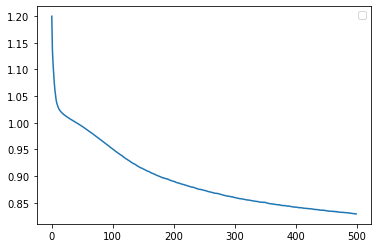

In [49]:
plt.plot(history.history['loss'])

plt.legend();

No handles with labels found to put in legend.


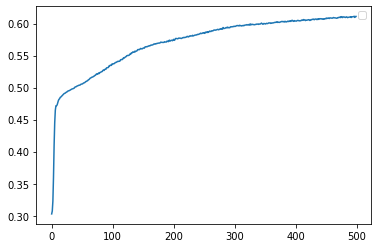

In [50]:
plt.plot(history.history['accuracy'])

plt.legend();

In [51]:
from sklearn.metrics import matthews_corrcoef
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import log_loss,accuracy_score,roc_auc_score,f1_score
from sklearn.metrics import classification_report

In [52]:
predictions = model_NN.predict(X_test)

y_predN=np.argmax(predictions,axis=1)
y_pred_accN = model_NN.predict(X_test)
#y_test = np.argmax(y_test, axis=1)

print(y_test.values)
print(y_predN)



[2 2 0 ... 2 2 1]
[2 2 0 ... 2 0 1]


In [ ]:
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

NN_Predictions=model_NN.predict(scaled_X_test)
#ypred = (NN_Predictions > 0.5).astype(int)

ypred=np.argmax(NN_Predictions,axis=1)


print('Log loss score with  : {0:0.4f}'. format(log_loss(y_test.values,ypred)))
#print('Model accuracy score with : {0:0.4f}'. format(matthews_corrcoef(y_test,ypred)))
print('Model roc score with : {0:0.4f}'. format(roc_auc_score(y_test,ypred,multi_class='ovr',average='weighted')))
print('Model f1 score with : {0:0.4f}'. format(f1_score(y_test, ypred)))
  

In [55]:
from xgboost import XGBClassifier
#from pandas import MultiIndex, Int64Index


best_hyperparams = {'colsample_bytree': 0.9080289013373745, 'gamma': 1.2419885617337658, 'max_depth': 8.0, 'min_child_weight': 4.0, 
'n_estimators': 238.0, 'reg_alpha': 41.0, 'reg_lambda': 0.05050398016408508}

rfc = XGBClassifier(n_estimators=int(best_hyperparams['n_estimators']), max_depth = int(best_hyperparams['max_depth']), 
gamma = best_hyperparams['gamma'],
                    reg_alpha = int(best_hyperparams['reg_alpha']),min_child_weight=int(best_hyperparams['min_child_weight']),
                    colsample_bytree=int(best_hyperparams['colsample_bytree']))
rfc.fit(X_train, y_train)
y_pred = rfc.predict_proba(X_test)
y_pred_acc = rfc.predict(X_test)

print(y_test.values)
print(y_pred)
print('Log loss score with  : {0:0.4f}'. format(log_loss(y_test.values,y_pred)))
print('Model accuracy score with : {0:0.4f}'. format(accuracy_score(y_test, y_pred_acc)))
print('Model ROC with : {0:0.4f}'. format(roc_auc_score(y_test.values, y_pred,multi_class='ovr',average='weighted')))

[2 2 0 ... 2 2 1]
[[0.32569274 0.29038143 0.38392583]
 [0.27808008 0.30243552 0.41948438]
 [0.37073758 0.31552282 0.3137396 ]
 ...
 [0.36673608 0.25411946 0.37914443]
 [0.34751704 0.23394182 0.41854107]
 [0.30432507 0.2944991  0.40117577]]
Log loss score with  : 1.0318
Model accuracy score with : 0.4890
Model ROC with : 0.6411


In [56]:
from sklearn.linear_model import LogisticRegression
model_LR=Pipeline([('scaler', MinMaxScaler()), ('Logmodel', LogisticRegression(C=0.001,penalty='l2',solver='saga'))])
#model_LR = LogisticRegression(C=0.001,penalty='l2',solver='saga')
model_LR.fit(X_train,y_train)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('Logmodel', LogisticRegression(C=0.001, solver='saga'))])

In [57]:
y_pred_acc1 = model_LR.predict(X_test)
y_pred2 = model_LR.predict_proba(X_test)

print('Log loss score with  : {0:0.4f}'. format(log_loss(y_test.values,predictions)))
print('Model accuracy score with : {0:0.4f}'. format(accuracy_score(y_test, y_pred_acc1)))
print('Model ROC with : {0:0.4f}'. format(roc_auc_score(y_test, y_pred2,multi_class="ovr",average='weighted')))

Log loss score with  : 12.8021
Model accuracy score with : 0.4713
Model ROC with : 0.6312
